In [8]:
# Import all required libraries
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import re
import nibabel as nib

# Additional imports for neuroimaging and atlas processing
from nilearn import datasets, masking, input_data, plotting
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [9]:
# Setup directories and plotting theme
RELI_DIR = Path("dset/derivatives/caps/interrater")
FIGURES_DIR = Path("dset/derivatives/figures")
# will use loop later to run over all subjects
OUT_DIR = Path("dset/derivatives/caps")


Loading Craddock atlas from local file...
Atlas loaded: dset/craddock2012_tcorr05_2level_270_2mm.nii
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 1

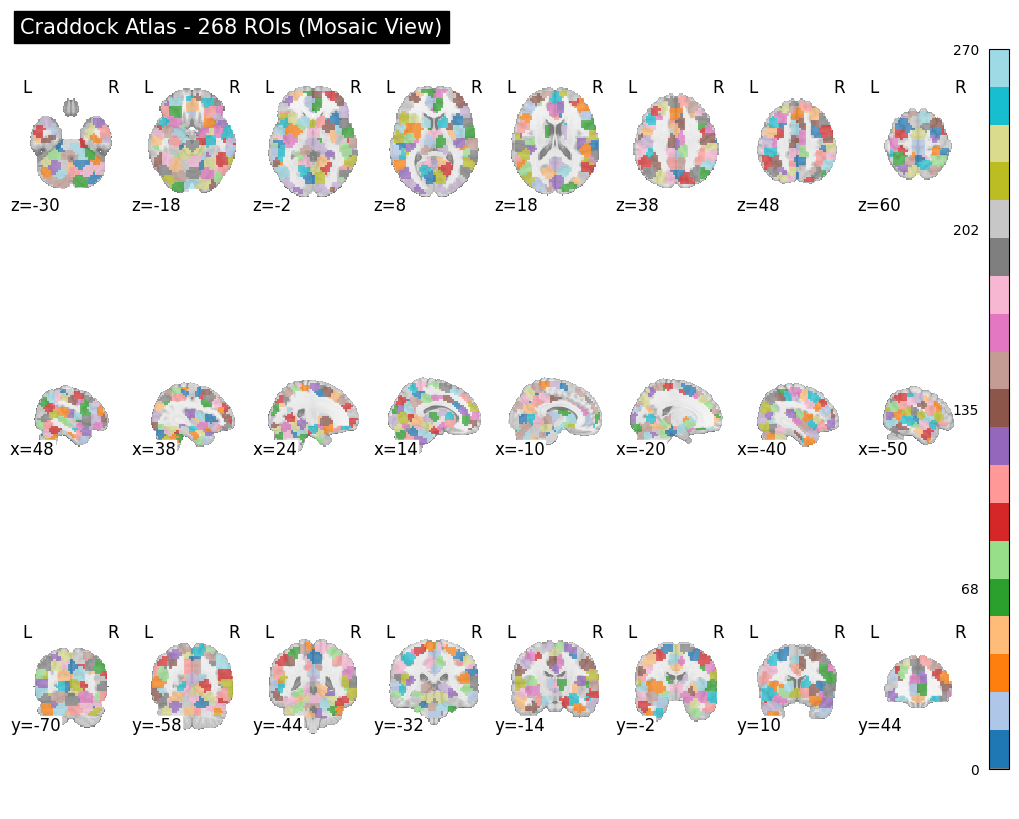

Atlas Statistics:
• Total ROIs: 268
• Label range: 1 - 270
• Brain voxels: 147,072
• Mean ROI size: 548.8 voxels
• Std ROI size: 106.6 voxels
• Min ROI size: 216 voxels
• Max ROI size: 848 voxels
• Atlas coverage: 16.3%


In [19]:
# Load Craddock atlas from local file
print("Loading Craddock atlas from local file...")

# Path to the unzipped atlas file
atlas_filename = Path("dset/craddock2012_tcorr05_2level_270_2mm.nii")

print(f"Atlas loaded: {atlas_filename}")

# Load the atlas to check its properties
atlas_img = nib.load(atlas_filename)
atlas_data = atlas_img.get_fdata()

# Get unique ROI labels (excluding background/0)
unique_labels = np.unique(atlas_data)
print(unique_labels)
unique_labels = unique_labels[unique_labels != 0]  # Remove background
n_rois = len(unique_labels)

print(f"Atlas shape: {atlas_data.shape}")
print(f"Number of ROIs: {n_rois}")
print(f"ROI labels range: {unique_labels.min()} to {unique_labels.max()}")


print(f"\nPlotting Craddock atlas...")

# Create figure
fig = plt.figure(figsize=(10, 8))

# Plot Mosaic view only
display = plotting.plot_roi(
    atlas_img,
    title=f'Craddock Atlas - {n_rois} ROIs (Mosaic View)',
    display_mode='mosaic',
    cut_coords=8,
    colorbar=True,
    cmap='tab20',
    figure=fig
)

plt.show()

# Create a detailed summary 
roi_sizes = []
for label in unique_labels:
    roi_size = np.sum(atlas_data == label)
    roi_sizes.append(roi_size)
brain_mask = atlas_data > 0
total_brain_voxels = np.sum(brain_mask)
atlas_coverage = (np.sum(atlas_data > 0) / np.prod(atlas_data.shape)) * 100


# Summary statistics
stats_text = f"""Atlas Statistics:
• Total ROIs: {n_rois}
• Label range: {unique_labels.min():.0f} - {unique_labels.max():.0f}
• Brain voxels: {total_brain_voxels:,}
• Mean ROI size: {np.mean(roi_sizes):.1f} voxels
• Std ROI size: {np.std(roi_sizes):.1f} voxels
• Min ROI size: {np.min(roi_sizes)} voxels
• Max ROI size: {np.max(roi_sizes)} voxels
• Atlas coverage: {atlas_coverage:.1f}%"""

print(stats_text)


In [11]:
# Create masker for extracting time series from ROIs
masker = input_data.NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=True,  #z-scores the time series
    memory='nilearn_cache',
    verbose=1
)

In [12]:
# Define all runs for each participant and episode
participant_data = {
    "sub-Blossom": {
        "episode_2": [1, 2, 3, 4, 5, 6, 7]  # Available runs for episode 2
    }
    # Add other participants as needed
}


In [13]:
# Extract BOLD time series and create z-scored participant matrices

# Initialize storage for participant-level matrices
all_participant_matrices = {}

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")
    
    participant_timeseries = []
    
    for episode_key, run_numbers in episodes.items():
        ep_num = int(episode_key.split('_')[1])
        
        print(f"\nProcessing Episode {ep_num} with {len(run_numbers)} runs...")
        
        for run_num in run_numbers:
            print(f"  Processing run {run_num}...")
            
            TASK_DIR = Path(f"dset/{sub_id}/ses-{ep_num:02d}/func") 
            
            # Construct the filename - note that run number is NOT zero-padded
            task_filename = f"{sub_id}_ses-{ep_num:02d}_task-strangerthings_run-{run_num}_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
            task_filepath = TASK_DIR / task_filename


            # Extract time series from 268 ROIs
            print(f"    Extracting time series from {task_filepath.name}...")
            time_series = masker.fit_transform(task_filepath)
                
            print(f"    Time series shape: {time_series.shape} (TRs x ROIs)")
                
            # Store z-scored time series for this run
            participant_timeseries.append(time_series)
                

    if participant_timeseries:
        # Concatenate all runs for this participant
        print(f"\nConcatenating {len(participant_timeseries)} runs for {sub_id}...")
        participant_matrix = np.vstack(participant_timeseries)
        
        print(f"Final participant matrix shape: {participant_matrix.shape}")
        print(f"  - Total TRs across all runs: {participant_matrix.shape[0]}")
        print(f"  - Number of ROIs (Craddock): {participant_matrix.shape[1]}")
        
        # Store the participant-level matrix
        all_participant_matrices[sub_id] = participant_matrix
        
        # Save the participant matrix
        output_dir = OUT_DIR / "timeseries_matrices"
        output_dir.mkdir(parents=True, exist_ok=True)
        
        output_file = output_dir / f"{sub_id}_zscore_timeseries_matrix.npy"
        np.save(output_file, participant_matrix)
        print(f"Saved participant matrix to: {output_file}")
        
        # Also save as CSV for easier inspection
        output_csv = output_dir / f"{sub_id}_zscore_timeseries_matrix.csv"
        df_matrix = pd.DataFrame(participant_matrix, 
                                columns=[f"ROI_{i+1:03d}" for i in range(participant_matrix.shape[1])])
        df_matrix.to_csv(output_csv, index=False)
        print(f"Saved participant matrix (CSV) to: {output_csv}")
        


print(f"\n{'='*60}")
print("PROCESSING COMPLETE")
print(f"{'='*60}")
print(f"Processed {len(all_participant_matrices)} participants:")
for sub_id, matrix in all_participant_matrices.items():
    print(f"  {sub_id}: {matrix.shape[0]} TRs × {matrix.shape[1]} ROIs")





PROCESSING sub-Blossom

Processing Episode 2 with 7 runs...
  Processing run 1...
    Extracting time series from sub-Blossom_ses-02_task-strangerthings_run-1_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz...
[NiftiLabelsMasker.wrapped] Loading regions from <nibabel.nifti1.Nifti1Image object at 0x11e9bbb60>
[NiftiLabelsMasker.wrapped] Resampling regions
[NiftiLabelsMasker.wrapped] Resampling regions
[NiftiLabelsMasker.wrapped] Finished fit
[NiftiLabelsMasker.wrapped] Finished fit
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker.filter_and_extract...
filter_and_extract(PosixPath('dset/sub-Blossom/ses-02/func/sub-Blossom_ses-02_task-strangerthings_run-1_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'), 
<nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x11f2225d0>, { 'background_label': 0,
  'clean_args': None,
  'clean_kwargs': {},
  'cmap': 'CMRmap_r',
  


PROCESSING sub-Blossom
Loaded time series matrix: (2121, 268)
  - Time points (TRs): 2121
  - ROIs: 268

Determining optimal number of clusters...
  k=2: Inertia=462083.69, Silhouette=0.152
  k=3: Inertia=425647.62, Silhouette=0.106
  k=4: Inertia=402793.44, Silhouette=0.093
  k=3: Inertia=425647.62, Silhouette=0.106
  k=4: Inertia=402793.44, Silhouette=0.093
  k=5: Inertia=384758.09, Silhouette=0.087
  k=5: Inertia=384758.09, Silhouette=0.087
  k=6: Inertia=373622.22, Silhouette=0.080
  k=7: Inertia=364701.38, Silhouette=0.073
  k=6: Inertia=373622.22, Silhouette=0.080
  k=7: Inertia=364701.38, Silhouette=0.073
  k=8: Inertia=357427.62, Silhouette=0.067
  k=9: Inertia=350835.06, Silhouette=0.065
  k=8: Inertia=357427.62, Silhouette=0.067
  k=9: Inertia=350835.06, Silhouette=0.065
  k=10: Inertia=344894.41, Silhouette=0.063
  k=11: Inertia=340258.81, Silhouette=0.063
  k=10: Inertia=344894.41, Silhouette=0.063
  k=11: Inertia=340258.81, Silhouette=0.063
  k=12: Inertia=335826.59, Silh

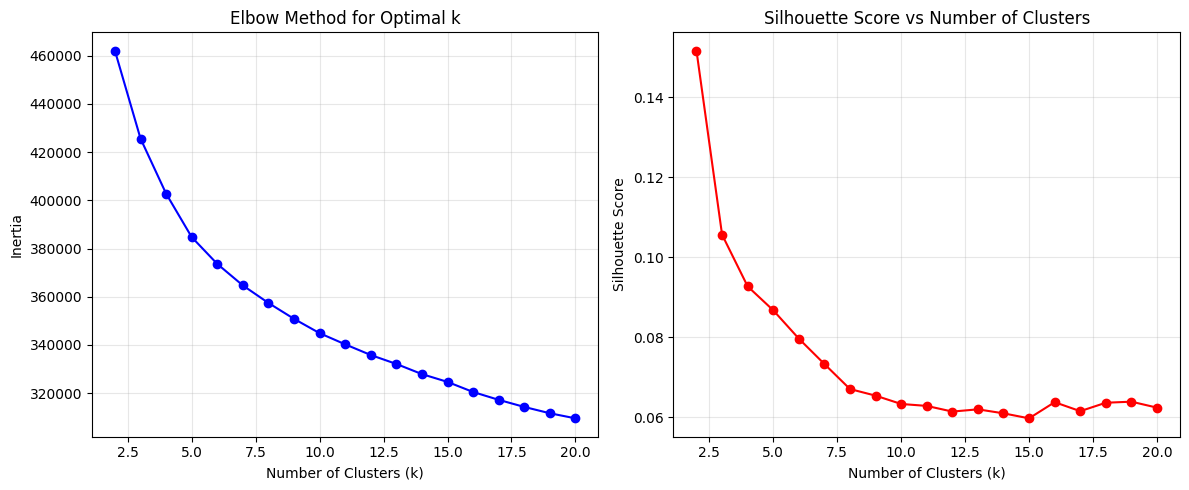


Elbow method results:
  - Optimal number of clusters (elbow): 4
  - Silhouette score at elbow k: 0.093
  - Inertia at elbow k: 402793.44

For comparison:
  - Best silhouette k: 2
  - Best silhouette score: 0.152

Optimal number of clusters: 4
Silhouette score at optimal k: 0.093

Performing final k-means clustering with k=4 (elbow method)...
Clustering results:
  - Total time points: 2121
  - Number of clusters: 4
  - Cluster 0: 255 time points (12.0%)
  - Cluster 1: 539 time points (25.4%)
  - Cluster 2: 519 time points (24.5%)
  - Cluster 3: 808 time points (38.1%)

Saved cluster labels to: dset/derivatives/caps/kmeans/sub-Blossom_cluster_labels.npy
Saved cluster centers (CAPs) to: dset/derivatives/caps/kmeans/sub-Blossom_cluster_centers.npy
Saved cluster labels (CSV) to: dset/derivatives/caps/kmeans/sub-Blossom_cluster_labels.csv
Saved cluster centers (CSV) to: dset/derivatives/caps/kmeans/sub-Blossom_cluster_centers.csv
Saved clustering metadata to: dset/derivatives/caps/kmeans/su

In [17]:
# Load saved time series matrices and perform k-means clustering

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")
    
    timeseries_file = OUT_DIR / f"timeseries_matrices/{sub_id}_zscore_timeseries_matrix.npy"
    
    if timeseries_file.exists():
        # Load the participant time series matrix
        participant_matrix = np.load(timeseries_file)
        print(f"Loaded time series matrix: {participant_matrix.shape}")
        print(f"  - Time points (TRs): {participant_matrix.shape[0]}")
        print(f"  - ROIs: {participant_matrix.shape[1]}")
        
        # Determine optimal number of clusters using elbow method and silhouette score
        print("\nDetermining optimal number of clusters...")
        k_range = range(2, 21)  # Test 2 to 20 clusters
        inertias = []
        silhouette_scores = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(participant_matrix)
            
            inertias.append(kmeans.inertia_)
            sil_score = silhouette_score(participant_matrix, cluster_labels)
            silhouette_scores.append(sil_score)
            
            print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")
        
        # Plot elbow curve and silhouette scores
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Elbow plot
        ax1.plot(k_range, inertias, 'bo-')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Optimal k')
        ax1.grid(True, alpha=0.3)
        
        # Silhouette score plot
        ax2.plot(k_range, silhouette_scores, 'ro-')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Score vs Number of Clusters')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Find optimal k based on elbow method
        # Calculate the rate of change (differences) in inertia
        inertia_diffs = np.diff(inertias)
        
        # Calculate the second derivative (rate of change of the rate of change)
        second_diffs = np.diff(inertia_diffs)
        
        # Find the elbow point - where the second derivative is maximum
        # (greatest change in the rate of decrease)
        elbow_idx = np.argmax(second_diffs) + 2  # +2 because we lost 2 points in double diff
        optimal_k = k_range[elbow_idx]
        
        # Also report the silhouette score for this k
        corresponding_silhouette = silhouette_scores[elbow_idx]
        
        print(f"\nElbow method results:")
        print(f"  - Optimal number of clusters (elbow): {optimal_k}")
        print(f"  - Silhouette score at elbow k: {corresponding_silhouette:.3f}")
        print(f"  - Inertia at elbow k: {inertias[elbow_idx]:.2f}")
        
        # For comparison, also show the k with best silhouette score
        best_sil_k = k_range[np.argmax(silhouette_scores)]
        max_silhouette = max(silhouette_scores)
        print(f"\nFor comparison:")
        print(f"  - Best silhouette k: {best_sil_k}")
        print(f"  - Best silhouette score: {max_silhouette:.3f}")
        
        print(f"\nOptimal number of clusters: {optimal_k}")
        print(f"Silhouette score at optimal k: {corresponding_silhouette:.3f}")
        
        # Perform final clustering with optimal k (from elbow method)
        print(f"\nPerforming final k-means clustering with k={optimal_k} (elbow method)...")
        final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        final_labels = final_kmeans.fit_predict(participant_matrix)
        
        # Get cluster information
        unique_labels, label_counts = np.unique(final_labels, return_counts=True)
        
        print(f"Clustering results:")
        print(f"  - Total time points: {len(final_labels)}")
        print(f"  - Number of clusters: {len(unique_labels)}")
        
        for i, (label, count) in enumerate(zip(unique_labels, label_counts)):
            percentage = (count / len(final_labels)) * 100
            print(f"  - Cluster {label}: {count} time points ({percentage:.1f}%)")
        
        # Save clustering results
        cluster_output_dir = OUT_DIR / "kmeans"
        cluster_output_dir.mkdir(parents=True, exist_ok=True)
        
        # Save cluster labels
        labels_file = cluster_output_dir / f"{sub_id}_cluster_labels.npy"
        np.save(labels_file, final_labels)
        print(f"\nSaved cluster labels to: {labels_file}")
        
        # Save cluster centers (CAPs)
        centers_file = cluster_output_dir / f"{sub_id}_cluster_centers.npy"
        np.save(centers_file, final_kmeans.cluster_centers_)
        print(f"Saved cluster centers (CAPs) to: {centers_file}")
        
        # Save cluster labels as CSV for easy inspection
        labels_csv_file = cluster_output_dir / f"{sub_id}_cluster_labels.csv"
        df_labels = pd.DataFrame({
            'timepoint': range(len(final_labels)),
            'cluster_label': final_labels
        })
        df_labels.to_csv(labels_csv_file, index=False)
        print(f"Saved cluster labels (CSV) to: {labels_csv_file}")
        
        # Save cluster centers (CAPs) as CSV for easy inspection
        centers_csv_file = cluster_output_dir / f"{sub_id}_cluster_centers.csv"
        df_centers = pd.DataFrame(
            final_kmeans.cluster_centers_,
            columns=[f"ROI_{i+1:03d}" for i in range(final_kmeans.cluster_centers_.shape[1])],
            index=[f"CAP_{i}" for i in range(final_kmeans.cluster_centers_.shape[0])]
        )
        df_centers.to_csv(centers_csv_file)
        print(f"Saved cluster centers (CSV) to: {centers_csv_file}")
        
        # Save clustering metadata
        metadata = {
            'n_clusters': optimal_k,
            'method': 'elbow',
            'silhouette_score': corresponding_silhouette,
            'inertia': final_kmeans.inertia_,
            'cluster_sizes': label_counts.tolist(),
            'total_timepoints': len(final_labels),
            'best_silhouette_k': best_sil_k,
            'max_silhouette_score': max_silhouette
        }
        
        metadata_file = cluster_output_dir / f"{sub_id}_clustering_metadata.txt"
        with open(metadata_file, 'w') as f:
            for key, value in metadata.items():
                f.write(f"{key}: {value}\n")
        print(f"Saved clustering metadata to: {metadata_file}")
        
        # Store results for further analysis
        globals()[f"{sub_id}_cluster_labels"] = final_labels
        globals()[f"{sub_id}_cluster_centers"] = final_kmeans.cluster_centers_
        globals()[f"{sub_id}_kmeans_model"] = final_kmeans
        
    else:
        print(f"ERROR: Time series file not found: {timeseries_file}")

print(f"\n{'='*60}")
print("CLUSTERING COMPLETE")
print(f"{'='*60}")

In [ ]:
# Create weighted spatial masks for each CAP
# For each CAP-derived brain state, separate positively and negatively activated regions

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")

    
    centers_file = OUT_DIR / f"kmeans/{sub_id}_cluster_centers.npy"
    
    if centers_file.exists():
        # Load the cluster centers (CAPs)
        cluster_centers = np.load(centers_file)
        n_clusters, n_rois = cluster_centers.shape
        
        print(f"Loaded cluster centers: {cluster_centers.shape}")
        print(f"  - Number of CAPs: {n_clusters}")
        print(f"  - Number of ROIs: {n_rois}")
        
        # Create output directory for spatial masks
        masks_output_dir = OUT_DIR / "spatial_masks"
        masks_output_dir.mkdir(parents=True, exist_ok=True)
        
        # Process each CAP
        for cap_idx in range(n_clusters):
            cap_values = cluster_centers[cap_idx, :]
            
            print(f"\nProcessing CAP {cap_idx}:")
            print(f"  - Activation range: [{cap_values.min():.3f}, {cap_values.max():.3f}]")
            
            # Separate positive and negative activations
            positive_mask = np.where(cap_values > 0, cap_values, 0)
            negative_mask = np.where(cap_values < 0, np.abs(cap_values), 0)  # Use absolute values for weights
            
            # Count regions with significant activations
            pos_regions = np.sum(positive_mask > 0)
            neg_regions = np.sum(negative_mask > 0)
            
            print(f"  - Positive regions: {pos_regions} ({pos_regions/n_rois*100:.1f}%)")
            print(f"  - Negative regions: {neg_regions} ({neg_regions/n_rois*100:.1f}%)")
            print(f"  - Positive weight sum: {positive_mask.sum():.3f}")
            print(f"  - Negative weight sum: {negative_mask.sum():.3f}")
            
            # Create weighted spatial masks for this CAP
            # Each mask contains the strength of activation for each ROI
            
            # Save positive activation mask
            pos_mask_file = masks_output_dir / f"{sub_id}_CAP{cap_idx}_positive_mask.npy"
            np.save(pos_mask_file, positive_mask)
            
            # Save negative activation mask  
            neg_mask_file = masks_output_dir / f"{sub_id}_CAP{cap_idx}_negative_mask.npy"
            np.save(neg_mask_file, negative_mask)
            
            # Create a combined mask dictionary for easy access
            cap_masks = {
                'positive': positive_mask,
                'negative': negative_mask,
                'original': cap_values,
                'positive_regions': pos_regions,
                'negative_regions': neg_regions,
                'positive_weight_sum': positive_mask.sum(),
                'negative_weight_sum': negative_mask.sum()
            }
            
            # Save combined mask data
            combined_mask_file = masks_output_dir / f"{sub_id}_CAP{cap_idx}_masks.npz"
            np.savez(combined_mask_file, **cap_masks)
            
            print(f"  - Saved positive mask: {pos_mask_file}")
            print(f"  - Saved negative mask: {neg_mask_file}")
            print(f"  - Saved combined masks: {combined_mask_file}")
            
            # Create NIfTI images for visualization (back-project to brain space)
            # Create positive activation image
            pos_brain_img = np.zeros_like(atlas_data)
            neg_brain_img = np.zeros_like(atlas_data)
            
            # IMPORTANT: Map ROI weights back to brain voxels using CORRECT label mapping
            # The unique_labels array contains the actual ROI labels from the atlas
            # The roi_idx corresponds to the position in our extracted time series
            for roi_idx in range(len(unique_labels)):
                if roi_idx < len(positive_mask):  # Safety check
                    roi_label = unique_labels[roi_idx]
                    roi_mask = (atlas_data == roi_label)
                    
                    # Only assign values if the ROI actually exists in the atlas
                    if np.any(roi_mask):
                        pos_brain_img[roi_mask] = positive_mask[roi_idx]
                        neg_brain_img[roi_mask] = negative_mask[roi_idx]
                    else:
                        print(f"    WARNING: No voxels found for ROI label {roi_label}")
            
            # Verify that we only have non-zero values inside the brain
            brain_mask = atlas_data > 0
            pos_outside_brain = np.sum((pos_brain_img > 0) & (~brain_mask))
            neg_outside_brain = np.sum((neg_brain_img > 0) & (~brain_mask))
            
            if pos_outside_brain > 0 or neg_outside_brain > 0:
                print(f"    ERROR: Found {pos_outside_brain} positive and {neg_outside_brain} negative voxels outside brain!")
                # Fix by masking out values outside the brain
                pos_brain_img[~brain_mask] = 0
                neg_brain_img[~brain_mask] = 0
                print(f"    Fixed by setting outside-brain voxels to zero")
            
            # Report statistics
            pos_nonzero = np.sum(pos_brain_img > 0)
            neg_nonzero = np.sum(neg_brain_img > 0)
            total_brain_voxels = np.sum(brain_mask)
            
            print(f"    Positive mask: {pos_nonzero} voxels ({pos_nonzero/total_brain_voxels*100:.2f}% of brain)")
            print(f"    Negative mask: {neg_nonzero} voxels ({neg_nonzero/total_brain_voxels*100:.2f}% of brain)")
            print(f"    Value ranges: pos=[{pos_brain_img.min():.3f}, {pos_brain_img.max():.3f}], neg=[{neg_brain_img.min():.3f}, {neg_brain_img.max():.3f}]")
            
            # Save as NIfTI files for visualization
            pos_nifti = nib.Nifti1Image(pos_brain_img, atlas_img.affine, atlas_img.header)
            neg_nifti = nib.Nifti1Image(neg_brain_img, atlas_img.affine, atlas_img.header)
            
            pos_nifti_file = masks_output_dir / f"{sub_id}_CAP{cap_idx}_positive_mask.nii.gz"
            neg_nifti_file = masks_output_dir / f"{sub_id}_CAP{cap_idx}_negative_mask.nii.gz"
            
            nib.save(pos_nifti, pos_nifti_file)
            nib.save(neg_nifti, neg_nifti_file)
            
            print(f"  - Saved positive NIfTI: {pos_nifti_file}")
            print(f"  - Saved negative NIfTI: {neg_nifti_file}")
        
        # Create summary of all CAPs for this subject
        summary_data = {
            'n_caps': n_clusters,
            'n_rois': n_rois,
            'cap_summaries': []
        }
        
        for cap_idx in range(n_clusters):
            cap_values = cluster_centers[cap_idx, :]
            positive_mask = np.where(cap_values > 0, cap_values, 0)
            negative_mask = np.where(cap_values < 0, np.abs(cap_values), 0)
            
            cap_summary = {
                'cap_id': cap_idx,
                'activation_range': [float(cap_values.min()), float(cap_values.max())],
                'positive_regions': int(np.sum(positive_mask > 0)),
                'negative_regions': int(np.sum(negative_mask > 0)),
                'positive_weight_sum': float(positive_mask.sum()),
                'negative_weight_sum': float(negative_mask.sum()),
                'mean_positive_weight': float(positive_mask[positive_mask > 0].mean()) if np.any(positive_mask > 0) else 0.0,
                'mean_negative_weight': float(negative_mask[negative_mask > 0].mean()) if np.any(negative_mask > 0) else 0.0
            }
            summary_data['cap_summaries'].append(cap_summary)
        
        # Save summary
        summary_file = masks_output_dir / f"{sub_id}_CAPs_summary.txt"
        with open(summary_file, 'w') as f:
            f.write(f"CAPs Spatial Masks Summary for {sub_id}\n")
            f.write("="*50 + "\n\n")
            f.write(f"Total CAPs: {n_clusters}\n")
            f.write(f"Total ROIs: {n_rois}\n\n")
            
            for cap_summary in summary_data['cap_summaries']:
                f.write(f"CAP {cap_summary['cap_id']}:\n")
                f.write(f"  Activation range: [{cap_summary['activation_range'][0]:.3f}, {cap_summary['activation_range'][1]:.3f}]\n")
                f.write(f"  Positive regions: {cap_summary['positive_regions']} ({cap_summary['positive_regions']/n_rois*100:.1f}%)\n")
                f.write(f"  Negative regions: {cap_summary['negative_regions']} ({cap_summary['negative_regions']/n_rois*100:.1f}%)\n")
                f.write(f"  Positive weight sum: {cap_summary['positive_weight_sum']:.3f}\n")
                f.write(f"  Negative weight sum: {cap_summary['negative_weight_sum']:.3f}\n")
                f.write(f"  Mean positive weight: {cap_summary['mean_positive_weight']:.3f}\n")
                f.write(f"  Mean negative weight: {cap_summary['mean_negative_weight']:.3f}\n\n")
        
        print(f"\nSaved CAPs summary: {summary_file}")
        
    else:
        print(f"ERROR: Cluster centers file not found: {centers_file}")

print(f"\n{'='*60}")
print("SPATIAL MASK CREATION COMPLETE")
print(f"{'='*60}")


CREATING WEIGHTED SPATIAL MASKS FOR ('sub-Blossom', {'episode_2': [1, 2, 3, 4, 5, 6, 7]})
ERROR: Cluster centers file not found: dset/derivatives/caps/kmeans/('sub-Blossom', {'episode_2': [1, 2, 3, 4, 5, 6, 7]})_cluster_centers.npy

SPATIAL MASK CREATION COMPLETE


In [18]:
# Create weighted spatial masks for each CAP
# For each CAP-derived brain state, separate positively and negatively activated regions

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")

    
    centers_file = OUT_DIR / f"kmeans/{sub_id}_cluster_centers.npy"


PROCESSING sub-Blossom
